# Python Hackathon August 2024 Team 3 - Code Rangers

In [91]:
#import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#ignore python warnings
warnings.filterwarnings('ignore')

1. Join all sport-related tables to produce one dataframe that has all athletes values. The final table should only have the same 5 columns: ID, time,power,RR, vo2. Write this dataframe to an excel file.

In [93]:
#Read data from excel worksheets
df_Kayaking =pd.read_excel("V02Max_Combined.xlsx",sheet_name="Kayaking")
df_Athletes=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Athletes")
df_Triathlon=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Triathlon")
df_Fencing=pd.read_excel("V02Max_Combined.xlsx",sheet_name="Fencing")

In [94]:
#concatenate all sports data to form a single dataframe
df_data = pd.concat([df_Fencing,df_Kayaking,df_Triathlon],ignore_index=True)

In [63]:
#verify data
df_data.describe()

,ID,time,RR,VO2,power
count,52062.000000,52062.00000,50914.000000,52062.000000,52062.000000
mean,9.518766,547.45914,443.583808,1.539104,106.528754
std,5.043902,386.29623,212.585991,0.799706,88.603627
min,1.000000,-219.87200,252.000000,0.069354,0.000000
25%,5.000000,244.29500,352.000000,0.972290,0.000000
50%,10.000000,542.03800,412.000000,1.419143,95.000000
75%,14.000000,822.13900,484.000000,2.043474,170.000000
max,18.000000,1504.05600,30500.000000,4.576774,335.000000


In [65]:
# Export Dataframe to Excel by eliminating index
df_data.to_excel("V02Max_Sports.xlsx",sheet_name="All_Sports",index=False)

2. Divide the rows into 3 parts: Warm up, GET(graded exercise test) and cool down using the data def. Label each row accordingly

In [97]:
# cooldown = time>0 and power =0
# warmup = time<0 and power =0
# GET(graded exercise test) =time>0 and power>0

df_data["stage"] = ""
df_data.loc[df_data["power"] == 0, "stage"] = "cooldown"
df_data.loc[df_data["time"] < 0, "stage"] = "warmup"
df_data.loc[df_data["power"] > 0, "stage"] = "GET"

In [69]:
# Verify top five rows
df_data.head()

,ID,time,RR,VO2,power,stage
0,1,-130.840,672.0,0.302008,0,warmup
1,1,-130.168,672.0,0.302008,0,warmup
2,1,-129.536,632.0,0.301336,0,warmup
3,1,-128.824,712.0,0.301336,0,warmup
4,1,-127.948,876.0,0.301336,0,warmup


In [99]:
#verify the count of rows for each stage
df_data["stage"].value_counts()

stage
GET         38733
cooldown     9088
warmup       4241
Name: count, dtype: int64

3. What was the average time each tested lasted excluding warm up for all athletes?

In [73]:
#get max time of individual athelete excluding warmup stage. calculate mean of max time.
avg_test_time = df_data[df_data["stage"] != "warmup"].groupby("ID")["time"].max().mean()
print("The average time each tested lasted excluding warm up for all athletes is ",avg_test_time)

The average time each tested lasted excluding warm up for all athletes is  1096.9759999999999


4. Athletes from which sport had the highest average cardiorespiratory fitness in terms of HRV?

In [101]:
df_RR = df_data.copy()
#calculated differences of RR_intervals
df_RR["HRV"]= df_RR.groupby("ID")["RR"].diff()
# Calculated HRV as standard deviation of RR_interval diffrences and updated to the athelete dataframe. 
df_Athletes = pd.merge(df_Athletes,df_RR.groupby("ID")["HRV"].std(), on="ID")

In [103]:
#calculated mean HRV value for each sport and displyed the highest average sport
high_HRV_sport=df_Athletes.groupby("sport")["HRV"].mean().sort_values(ascending=False).head(1)
print("The sport that has the highest average cardiorespiratory fitness in terms of HRV is",high_HRV_sport)

The sport that has the highest average cardiorespiratory fitness in terms of HRV is sport
kayak    170.640909
Name: HRV, dtype: float64


5. What was the average time each test lasted (including warm up) for all athletes?

In [105]:
#total test time calculated as difference between the maximum and minimum of time
total_time_taken= df_data.groupby("ID")["time"].max() - df_data.groupby("ID")["time"].min()
avg_total_time = total_time_taken.mean()
print("The average time each tested lasted including warm up for all athletes is ",avg_total_time)

The average time each tested lasted including warm up for all athletes is  1277.8059999999998


8. What are the names of the kayaking athletes?

In [107]:
#filterd athelets with sport as kayak and printed their names
df_Athletes_kayak = df_Athletes[df_Athletes["sport"]=="kayak"]
print("The names of the kayaking athletes are :")
print(df_Athletes_kayak["First Name"].values + " " + df_Athletes_kayak["Last Name"].values)

The names of the kayaking athletes are :
['Isabella Griffin' 'Caleb Dixon' 'Mia Carpenter' 'Harper Mitchell'
 'Mason Wallace' 'Logan Anderson']


9. What was the average HRV of the triathletes?

In [109]:
#From HRV calcultaed from 4th question calculated the mean of triathlon athletes 
print("The average HRV of triathletes is : ",df_Athletes[df_Athletes["sport"]=="triathlon"]["HRV"].mean())

The average HRV of triathletes is :  29.293777318936115


12. What were the Highest 3 V02 Maxes recorded. Display all 3 names, sport and personal V02 Maxes.

In [117]:
#Calculated sum of VO2 and added a temp column (VO2) in Athletes table
df_Athletes = pd.merge(df_Athletes,df_data.groupby("ID")["VO2"].sum(), on="ID")
#calculated VO2 max as sum of V02 by weight of Athlete
df_Athletes["VO2_max"]= df_Athletes["VO2"]/df_Athletes["Weight"]
#dropped the temp column VO2
df_Athletes=df_Athletes.drop("VO2",axis=1)

In [119]:
#Displayed the top three VO2_max Athletes
print("The highest three VO2_max are for the following athletes :")
df_Athletes.sort_values(by="VO2_max",ascending=False)[["First Name","Last Name","sport","VO2_max"]].head(3).reset_index(drop=True)

The highest three VO2_max are for the following athletes :


,First Name,Last Name,sport,VO2_max
0,Caleb,Dixon,kayak,92.258212
1,Mia,Carpenter,kayak,90.758693
2,Isabella,Griffin,kayak,89.586903


13. Calculate the year of birth of each athlete and store it as a column in the tables.

In [122]:
# year of birth is year data taken(2017 ) substracted by age
df_Athletes["birth_year"]= 2017-df_Athletes["age"]
df_Athletes

,ID,age,Weight,Height,P_vt1,P_vt2,sport,Gender,Ethnicity,First Name,Last Name,HRV,BMI,VO2_max,birth_year
0,1,15,53.7,161,50,140,fencing,Female,African,Olivia,Martinez,25.844717,20.716793,42.807730,2002
1,2,15,56.2,162,80,127,fencing,Male,African,Ethan,Reynolds,40.725284,21.414419,38.632602,2002
2,3,16,89.9,191,155,300,fencing,Male,White,Jackson,Harper,20.398306,24.642965,69.705657,2001
3,4,16,76.5,180,215,275,fencing,Male,White,Liam,Sanchez,33.334630,23.611111,76.989878,2001
4,5,17,76.4,186,110,172,fencing,Female,White,Ava,Thompson,115.319339,22.083478,86.742579,2000
5,6,17,65.6,169,131,186,fencing,Female,White,Sophia,Rodriguez,447.371626,22.968383,71.679465,2000
6,7,15,49.8,165,65,108,fencing,Female,White,Grace,Simmons,23.696380,18.292011,38.403988,2002
7,8,15,51.2,165,80,133,fencing,Female,White,Aiden,Bennett,504.482368,18.806244,44.822092,2002
8,9,14,57.1,176,50,125,fencing,Female,African,Chloe,Price,22.540326,18.433626,49.697342,2003
9,10,14,58.8,177,101,162,fencing,Female,African,Lily,Jordan,26.865031,18.768553,55.122171,2003


14. What were the lowest 3 V02 Maxes recorded. Display all 3 names, sport and personal V02 Maxes. 

In [125]:
#Displayed the bottom three VO2_max Athletes
print("The lowest three VO2_max are for the following athletes :")
df_Athletes.sort_values(by="VO2_max",ascending=True)[["First Name","Last Name","sport","VO2_max"]].head(3).reset_index(drop=True)

The lowest three VO2_max are for the following athletes :


,First Name,Last Name,sport,VO2_max
0,Grace,Simmons,fencing,38.403988
1,Ethan,Reynolds,fencing,38.632602
2,Olivia,Martinez,fencing,42.807730


16. Calculate the BMI of every athlete and display it as a list.

In [111]:
#calculated BMI as weight(kg)(height(meter))^2
df_Athletes["BMI"] = df_Athletes["Weight"]/(df_Athletes["Height"]/100)**2
print("The list of athletes and their BMI is :")
df_Athletes.reset_index()[["First Name","Last Name","BMI"]].values.tolist()

The list of athletes and their BMI is :


[['Olivia', 'Martinez', 20.716793333590523],
 ['Ethan', 'Reynolds', 21.414418533760095],
 ['Jackson', 'Harper', 24.642964831007923],
 ['Liam', 'Sanchez', 23.61111111111111],
 ['Ava', 'Thompson', 22.083477858711987],
 ['Sophia', 'Rodriguez', 22.968383459962887],
 ['Grace', 'Simmons', 18.29201101928375],
 ['Aiden', 'Bennett', 18.80624426078972],
 ['Chloe', 'Price', 18.433626033057852],
 ['Lily', 'Jordan', 18.768553097768837],
 ['Isabella', 'Griffin', 25.600772853520105],
 ['Caleb', 'Dixon', 25.680074054167036],
 ['Mia', 'Carpenter', 25.05300247842575],
 ['Harper', 'Mitchell', 21.305700899422046],
 ['Mason', 'Wallace', 21.464305029745812],
 ['Logan', 'Anderson', 21.253471802922352],
 ['Lucas', 'Foster', 16.395463510848124],
 ['Owen', 'Myers', 15.902900176253803]]

11. Create any 3d plot using any data. Values do not have to be from the dataset given. 

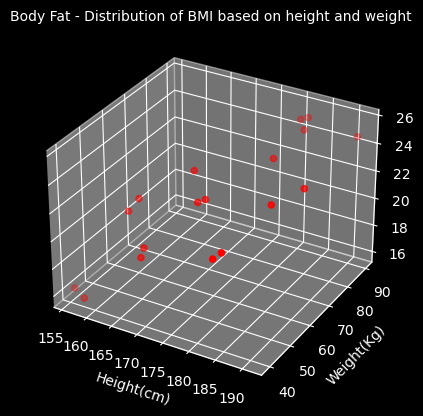

In [114]:
#created 3D plot using BMI,Height and weight from Athletes table:
plt.style.use("dark_background")
ax = plt.axes(projection = "3d")

ax.set_title("Body Fat - Distribution of BMI based on height and weight", fontsize=10)
ax.set_xlabel("Height(cm)")
ax.set_ylabel("Weight(Kg)")
ax.set_zlabel("BMI(Kg/m^2)")

ax.scatter(df_Athletes["Height"],df_Athletes["Weight"],df_Athletes["BMI"],color= 'r')
plt.show()